In [2]:
import os
import shutil

def prepare_dataset(yolo_dir, output_dir):
    """
    Converts YOLO-style annotations into a class-based directory structure.
    Args:
        yolo_dir: Path to YOLO-style dataset folder (contains `images` and `labels`).
        output_dir: Path to the output directory.
    """
    images_dir = os.path.join(yolo_dir, "images")
    labels_dir = os.path.join(yolo_dir, "labels")

    # Create the output directory if not exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        image_name = os.path.splitext(label_file)[0] + ".jpg"  # Assuming images are in `.jpg`
        image_path = os.path.join(images_dir, image_name)

        if not os.path.exists(image_path):
            continue  # Skip if image does not exist

        # Read the label file
        with open(label_path, "r") as file:
            lines = file.readlines()
            if not lines:
                continue  # Skip empty label files
            class_id = int(lines[0].split()[0])  # Take the first class ID

            # Create class folder
            class_folder = os.path.join(output_dir, f"class_{class_id}")
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)

            # Copy the image to the class folder
            shutil.copy(image_path, os.path.join(class_folder, image_name))

# Prepare training, validation, and test datasets


# First file is the file path of the original dataset which you'd download from roboflow, second is the new file which you'd be creating
prepare_dataset(r"C:\Users\Ramachandra\Downloads\PlantsDetector.v2i.yolov8\train", r"C:\Users\Ramachandra\OneDrive\Desktop\saad\otrain")
prepare_dataset(r"C:\Users\Ramachandra\Downloads\PlantsDetector.v2i.yolov8\valid", r"C:\Users\Ramachandra\OneDrive\Desktop\saad\oval")
prepare_dataset(r"C:\Users\Ramachandra\Downloads\PlantsDetector.v2i.yolov8\test", r"C:\Users\Ramachandra\OneDrive\Desktop\saad\otest")


Found 3125 images belonging to 10 classes.
Found 297 images belonging to 10 classes.
Found 149 images belonging to 10 classes.
5/5 [==============================] - 3s 599ms/step - loss: 0.8881 - accuracy: 0.7114
Test Accuracy: 0.71


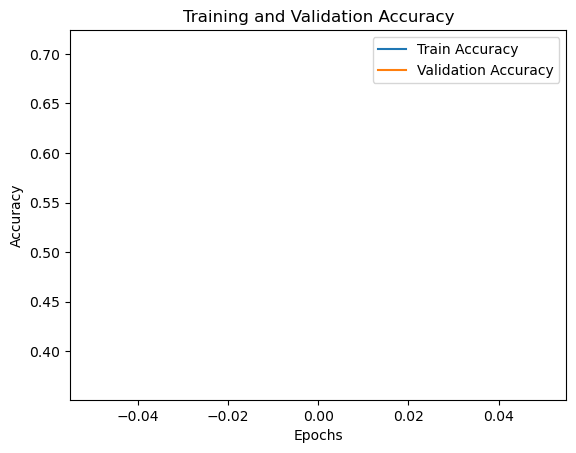

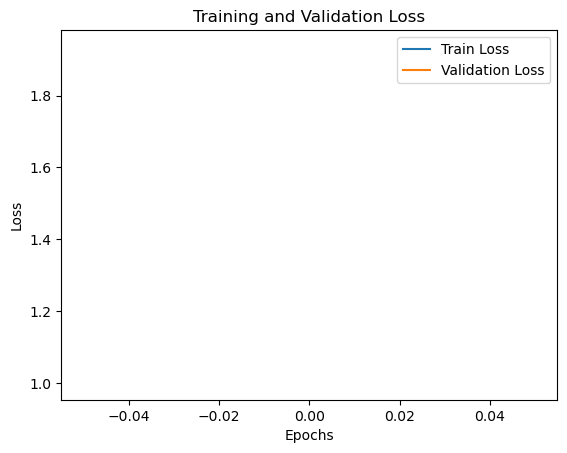

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Dataset directories

# Give the file path of the newly created directories in the previous step
train_dir = r"C:\Users\Ramachandra\OneDrive\Desktop\saad\otrain"
val_dir = r"C:\Users\Ramachandra\OneDrive\Desktop\saad\oval"
test_dir = r"C:\Users\Ramachandra\OneDrive\Desktop\saad\otest"

# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = len(os.listdir(train_dir))  # Dynamically count classes

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Load Pre-Trained MobileNetV2 Model
# Without using this we get low accuracy ie around 10%, hence use pretrained model. I'm using Mobilenet


base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model layers (prevent training on pre-trained layers)
base_model.trainable = False

# Build the Transfer Learning Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensionality
    layers.Dropout(0.5),              # Dropout for regularization
    layers.Dense(num_classes, activation="softmax")  # Output layer
])

# Compile the Model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the Model
history = model.fit(
    train_generator,
    epochs=1,  # Use 10-20 epochs i have used only 1 due to CPU health and time constraints
    validation_data=val_generator
)


# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_generator,
    epochs=1,  # Fine-tune for an additional 10 epochs im doing only once 
    validation_data=val_generator
)

# Save the Model
model.save("plant_classifier_transfer_model.h5")

# Evaluate the Model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot Training Results
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [10]:
# Predict on Test Data
predictions = model.predict(test_generator)
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Display a Few Predictions
import numpy as np

for i in range(5):
    print(f"True: {class_labels[true_classes[i]]}, Predicted: {class_labels[predicted_classes[i]]}")


5/5 [==============================] - 3s 430ms/step
True: class_0, Predicted: class_0
True: class_0, Predicted: class_0
True: class_0, Predicted: class_2
True: class_0, Predicted: class_0
True: class_0, Predicted: class_0
